# CSCI-P556, Fall 2018
# Assignment 4

We will be using the the following data sets in this assignment:



*   [Ionosphere](https://archive.ics.uci.edu/ml/datasets/ionosphere)
*   [Car Evaluation](https://archive.ics.uci.edu/ml/datasets/car+evaluation)
*   [Credit Approval](https://archive.ics.uci.edu/ml/datasets/Credit+Approval)

Download them to the same folder as this .ipynb file. Take a look at the 'Data Set Descriptions' links in the above links.


## Problem 1: K-Fold Cross Validation [10 points]

Implement k- fold cross validation and select k = 5 to create 5 training and 5 test data sets from each data
set and save these 30 files. You will use these data sets for model comparison and parameter selection.

In [17]:
import numpy as np
import pandas as pd
import random
import seaborn as sb
import matplotlib.pyplot as plt
# Code for problem 1 goes here
random.seed(42)
def createKFold(Data,K):
##data to be passed as Dataframe
##returns k training and k test sets
    
    dictOfSplitIndices = {} ##has k keys
    statListOfIndices = list(Data.index)
    listOfIndices = list(Data.index)
    
    (rows,cols) = Data.shape
    subSampleNum = int(rows/K)
    for i in range(K):
        dictOfSplitIndices[i] = random.sample(listOfIndices,subSampleNum)
        listOfIndices = set(listOfIndices) - set(dictOfSplitIndices[i])
#     print(dictOfSplitIndices)
    
    listOfDataSets = []
    for i in range(K):
        
        TrainData = Data.loc[~Data.index.isin(dictOfSplitIndices[i]),:]
        TestData = Data.loc[dictOfSplitIndices[i],:]
        listOfDataSets.append((TrainData,TestData))
    
    
    return listOfDataSets #each row train and test data
    



In [18]:


"""
code for data cleaning (nothing to with K-fold)
"""
#transofrming all objet dtypes to categorical
def changeDtypes(df,from_dtype,to_dtype):
    #changes inplace, affects the passed dataFrame
    df[df.select_dtypes(from_dtype).columns] = df.select_dtypes(from_dtype).astype(to_dtype)

##normalising 
def normaliseContinousVars(df):
    continuousVariables = df.select_dtypes('int64').columns.tolist() + df.select_dtypes('float64').columns.tolist()
    df[continuousVariables] = df[continuousVariables].apply(lambda x : (x-x.mean())/x.std() , axis=1)


##getting variables that have missing values
# print(BankMarketing_train_1.columns[BankMarketing_train_1.isna().any()])


##recalculate the levels in all categorical variables befor one hot encoding
def dropUnusedCategories(df):
    categoricalVariables = df.select_dtypes('category').columns.tolist()
    for columns in categoricalVariables:
        df[columns] = df[columns].cat.remove_unused_categories()



##fill nas with mode of the catrgorical data for continoue replacae by median or by knn imputaion
# BankMarketing_train_1.info()
def fill_Mode_Median(df):
    continuousVariables = df.select_dtypes('int64').columns.tolist() + df.select_dtypes('float64').columns.tolist()
    categoricalVariables = df.select_dtypes('category').columns.tolist()
    df[continuousVariables] = df[continuousVariables].fillna(df[continuousVariables].median())
    df[categoricalVariables] = df[categoricalVariables].fillna(df[categoricalVariables].mode().iloc[0])#mode could have multiple values

    
 #transofrming all objet dtypes to categorical
def changeDtypes(df,from_dtype,to_dtype):
    #changes inplace, affects the passed dataFrame
    df[df.select_dtypes(from_dtype).columns] = df.select_dtypes(from_dtype).astype(to_dtype)   

    
##write a data pipleline functions
def pipelineFunc(df):
    changeDtypes(df,'object','category')
    normaliseContinousVars(df)
    dropUnusedCategories(df)
    
    ##making a copy to avoid warnings 
    ##splittnig Predictors and Target variables
    df_X = df.iloc[:,:-1].copy()
    
    df_Y = df.iloc[:,[-1]].copy()
    
    ##fill median for continous and mode for categorical
    fill_Mode_Median(df_X)
    
    ##listing cateorical variables
    categoricalVariables = df_X.select_dtypes('category').columns.tolist()
    continuousVariables = df.select_dtypes('int64').columns.tolist() + df.select_dtypes('float64').columns.tolist()
#     print("the follwing are the categorical variables : ", categoricalVariables)
#     print("the follwing are the caontinous variables : ", continuousVariables)
    
    ##one hot encoding
    df_X = pd.get_dummies(df_X,drop_first= True)
    
    return df_X , df_Y   


## Code for creaing K FOlds and saving
def genKFoldsAndSave(Data, Name ,K):
    listOfDataSets = createKFold(Data,K)
    for (count,(TrainData, TestData)) in enumerate(listOfDataSets):
        TrainData.to_csv(Name + "_"+ "train"+ "_" + str(count),index = False)
        TestData.to_csv(Name + "_"+ "test"+ "_" + str(count),index = False)

###loading data and initial preprocessing case handling for DataCredit

DataIonosphere = pd.read_table("./ionosphere.data",delimiter= ",",header= None)

DataCar = pd.read_table("./car.data",delimiter= ",",header= None)


DataCredit = pd.read_table("./crx.data",delimiter= ",",header= None)

#extra processing for DataCredit
DataCredit.replace('?' , np.nan,inplace = True)
DataCredit[[1,7,10,13,14]] = DataCredit[[1,7,10,13,14]].astype('float64')


In [19]:
##data cleaning 
DataIonosphereX,DataIonosphereY = pipelineFunc(DataIonosphere)
DataCarX,DataCarY = pipelineFunc(DataCar)
DataCreditX,DataCreditY = pipelineFunc(DataCredit)
DataIonosphere = pd.concat([DataIonosphereX, DataIonosphereY], axis=1)
DataCar = pd.concat([DataCarX, DataCarY], axis=1)
DataCredit = pd.concat([DataCreditX, DataCreditY], axis=1)


###genrating K folds and saving
genKFoldsAndSave(DataCar,"./DataCar",5)
genKFoldsAndSave(DataIonosphere,"./DataIonosphere",5)
genKFoldsAndSave(DataCredit,"./DataCredit",5)

## Problem 2: K-Nearest Neighbors (KNN) [30 points]

---



2.1 Implement KNN algorithm with two different distance functions. You can either use an existing distance
functions, i.e., Euclidean or design your own.

In [20]:
# Code for problem 2.1 goes here
import math

from sklearn.metrics import accuracy_score
class  KNN:
    

    def __init__ (self,distMeasureP = 1, RegOrClass= 'Classification'):
        self.PNormVal = distMeasureP

        self.RegOrClass = RegOrClass
        
    def train(self,X,Y):
        self.trainX  =X
        self.trainY = Y

    def calcDistanceMatrix(self,newDataX):
        
        ##returns Y
        #for every row in newDataX
        ##apply calculate distance func on train 
        ##create a data frame
        ##choose leastK
        predictionDict = {}
#         for index, row in newDataX.iterrows():
        newDataXAsArray = np.array(newDataX)
        trainXAsArray = np.array(self.trainX)
        
        for newDataIndex,newDataRow in enumerate(newDataXAsArray):
            listOfDistances = []
            for trainDataIndex,trainDataRow in enumerate(trainXAsArray):
#             predictionDict[index] =  self.trainX.applymap(lambda x : self._calculateDist(x,newDataRow))
                listOfDistances.append(self._calculateDist(newDataRow,trainDataRow))
            predictionDict[newDataIndex] = listOfDistances 
        

        
        self.predictionDf = pd.DataFrame(predictionDict)
        self.predictionDf.columns = ['col'+ str(num) for num in self.predictionDf.columns]
        
       
        
    def _preprocess():
        """
        On error try preprocess function
        """
        ##other preprocesing if needed
        self.trainX = self.TrainX.apply(pd.to_numeric, errors='coerce')
        self.trainX[self.trainX.select_dtypes('uint8').columns] = df.select_dtypes('uint8').astype('int8')
        
        pass
    def _calculateDist(self,X1,X2):

        distance = abs(pow(sum(pow(abs(X1-X2),self.PNormVal)),1/self.PNormVal))
#         distance = math.sqrt(sum((X1-X2)**2))

        return distance
        
    def getPredictionsByK(self,KNearest = 3):
        self.KNearest = KNearest
        if self.RegOrClass == 'Classification':
            predictionList = []
            for col in self.predictionDf:
                predictionList.append(pd.concat([self.predictionDf[col],self.trainY],axis = 1).sort_values(by = col).iloc[:,-1][:KNearest].mode()[0])
            return predictionList
        if self.RegOrClass == 'Regression':
            pass
            
    def score(self,yPred,yTrue):
        return accuracy_score(yPred,yTrue)
        
    
    



2.2 Use the data sets obtained in problem 1 to determine the optimal k over each data set for KNN algorithm. For 5 different k values, plot the test error for each data set. Total number of figures = 3 (data set number) × 2 (distance function number) = 6. Report the best k and distance function for each data set.

*Please note that I am taking the Minimum accuracy amongst all the cross validations to be conservative about the figures*

In [21]:
##loading all data sets

DataCarAll = {}
DataCreditAll = {}
DataIonosphereAll = {}

for i in range(5):
    DataCarAll[i] = {}
    DataCarAll[i]['Train'] = pd.read_csv('./DataCar_train_'+str(i))
    DataCarAll[i]['Train'] = pd.read_csv('./DataCar_train_'+str(i))
    
    DataCarAll[i]['Test'] = pd.read_csv('./DataCar_test_'+str(i))
    DataCreditAll[i] = {}
    DataCreditAll[i]['Train'] = pd.read_csv('./DataCredit_train_'+str(i))
    DataCreditAll[i]['Test'] = pd.read_csv('./DataCredit_test_'+str(i))
    DataIonosphereAll[i] = {}
    DataIonosphereAll[i]['Train'] = pd.read_csv('./DataIonosphere_train_'+str(i))
    DataIonosphereAll[i]['Test'] = pd.read_csv('./DataIonosphere_test_'+str(i))


In [22]:

"""
Distance measure denotes the power for the minkowski distance:
When Dist Measure = 2 its Eucedian
When Dist Meacure = 1 its Manhattan Distance
"""

def searchBestKinKNN(DataDict):
    KnAccuracy = {'K':[],'DistMeasure':[],'Accu': []}
    
    for distMeasure in [1,2]:
        print('Done')
        distMatrixDict = {}
        for k in range(1,10,1):
            accuracyDiffSets = []
            for setNum in DataDict:
                if setNum not in distMatrixDict:
                    distMatrixDict[setNum] = KNN(distMeasureP = distMeasure, RegOrClass= 'Classification')
                
                    distMatrixDict[setNum].train(DataDict[setNum]['Train'].iloc[:,:-1],DataDict[setNum]['Train'].iloc[:,-1])
                    distMatrixDict[setNum].calcDistanceMatrix(DataDict[setNum]['Test'].iloc[:,:-1])
      
            # Train the model on training data
                ypred = distMatrixDict[setNum].getPredictionsByK(k)
                accuracyDiffSets.append(accuracy_score(y_pred=ypred,y_true=DataDict[setNum]['Test'].iloc[:,-1]))
            
            accuracyAtDiffK =  min(accuracyDiffSets)
            KnAccuracy['K'].append(k)
            KnAccuracy['Accu'].append(accuracyAtDiffK)
            KnAccuracy['DistMeasure'].append(distMeasure)
                
    KnAccuracyDf = pd.DataFrame(KnAccuracy)
    maxValAccu = KnAccuracyDf[KnAccuracyDf['Accu']==KnAccuracyDf['Accu'].max()]
    print("Best Accuracy is at the following configuration")
    print(maxValAccu)
    return(KnAccuracyDf)
    


Done
Done
Best Accuracy is at the following configuration
   K  DistMeasure      Accu
1  2            1  0.871429
2  3            1  0.871429
3  4            1  0.871429


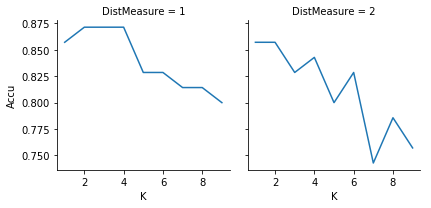

In [23]:
InonospehereKDistDf = searchBestKinKNN(DataIonosphereAll)
g = sb.FacetGrid(InonospehereKDistDf, col="DistMeasure")
g.map(plt.plot, "K",'Accu')

Done
Done
Best Accuracy is at the following configuration
    K  DistMeasure     Accu
7   8            1  0.84058
16  8            2  0.84058


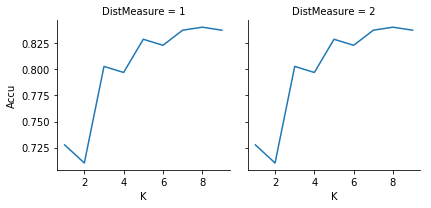

In [24]:
CarKDistDf = searchBestKinKNN(DataCarAll)
g = sb.FacetGrid(CarKDistDf, col="DistMeasure")
g.map(plt.plot, "K",'Accu')

Done
Done
Best Accuracy is at the following configuration
   K  DistMeasure      Accu
4  5            1  0.789855
7  8            1  0.789855


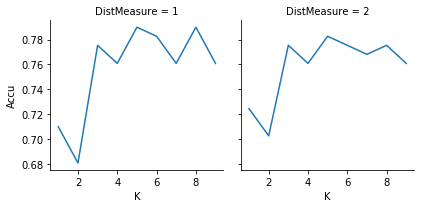

In [25]:

###KNN implementation for Credit data
CreditKDistDf = searchBestKinKNN(DataCreditAll)
g = sb.FacetGrid(CreditKDistDf, col="DistMeasure")
g.map(plt.plot, "K",'Accu')

2.3 Use sklearn's KNN implementation for validation.

*Please note that I am taking the minimum accuracy amongst the CrossValidation sets , to be conservative in reprting the figures*

In [26]:
# Code for problem 2.3 goes here



from sklearn import neighbors

def SklearnSearchBestKinKNN(DataDict):
    KnAccuracy = {'K':[],'DistanceMeasure' : [],'Accu': []}
    for distMetric in ['l1','l2']:
        for k in range(1,10,1):
            accuracyAtDiffSets = []
            for setNum in DataDict:

                KNNClassifier = neighbors.KNeighborsClassifier(n_neighbors = k,metric = distMetric)
                # Train the model on training data
                KNNClassifier.fit(DataDict[setNum]['Train'].iloc[:,:-1],DataDict[setNum]['Train'].iloc[:,-1])
                accuracyAtDiffSets.append(KNNClassifier.score(DataDict[setNum]['Test'].iloc[:,:-1],DataDict[setNum]['Test'].iloc[:,-1]))
            accuracyAtDiffK = min(accuracyAtDiffSets)
            KnAccuracy['K'].append(k)
            KnAccuracy['Accu'].append(accuracyAtDiffK)
            KnAccuracy['DistanceMeasure'].append(distMetric)
                
    KnAccuracyDf = pd.DataFrame(KnAccuracy)
    maxValAccu = KnAccuracyDf[KnAccuracyDf['Accu']==KnAccuracyDf['Accu'].max()]
    print("Best Accuracy is at the following configuration")
    print(maxValAccu)
    return KnAccuracyDf
    



Best Accuracy is at the following configuration
   K DistanceMeasure      Accu
1  2              l1  0.871429
2  3              l1  0.871429
3  4              l1  0.871429


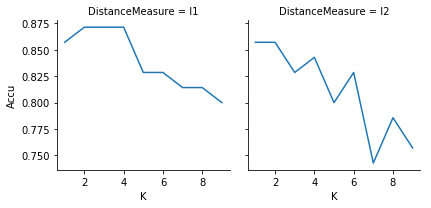

In [27]:

#SK Learn implementation for KNN Data : Ionosphere

IonosphereKDistDfSkl = SklearnSearchBestKinKNN(DataIonosphereAll)
g = sb.FacetGrid(IonosphereKDistDfSkl, col="DistanceMeasure")
g.map(plt.plot, "K",'Accu')

Best Accuracy is at the following configuration
    K DistanceMeasure      Accu
7   8              l1  0.834783
16  8              l2  0.834783


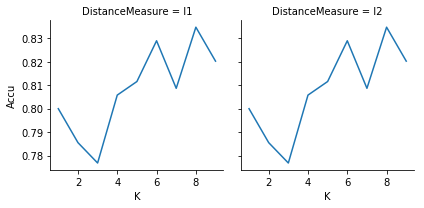

In [28]:
#SK Learn implementation for KNN Data : Car Evaluation
CarKDistDfSkl = SklearnSearchBestKinKNN(DataCarAll)
g = sb.FacetGrid(CarKDistDfSkl, col="DistanceMeasure")
g.map(plt.plot, "K",'Accu')

Best Accuracy is at the following configuration
   K DistanceMeasure      Accu
4  5              l1  0.789855
7  8              l1  0.789855


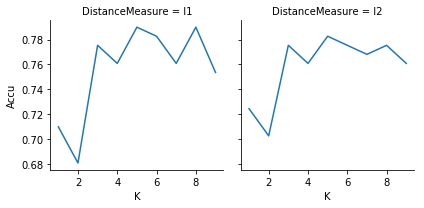

In [96]:
#SK Learn implementation for KNN Data : Credit Risk

CreditKDistDfSkl = SklearnSearchBestKinKNN(DataCreditAll)
g = sb.FacetGrid(CreditKDistDfSkl, col="DistanceMeasure")
g.map(plt.plot, "K",'Accu')


## Problem 3: Naive Bayes Classifier [30 points]

3.1 Implement Naive Bayes classifier. You may need to modify it for categorical variables. To handle unseen feature values, you may need to make use Laplace smoothing or the m-estimate of conditional probability method.

In [30]:
# Code for problem 3.1 goes here

class NaiveBayes:
    def __init__ (self,RegOrClass = 'Classification'):
        pass
    def train(self,X,Y,listOfContinousVars):
        self.TrainX = X
        self.TrainY = Y
        self._fullTrainData = pd.concat([X,Y],axis = 1)
        self._listOfNumericCols = listOfContinousVars
        self._SMALL_PROB = 1/100000000
        ##P(Class)##prior
        ###series with index of classes in Y
        self._classYProbability = self.TrainY.value_counts()/self.TrainY.value_counts().sum()
        
        
 
        ##P(feature/class)
        ##if feature is categorical
        
        
        self._dictOfProbOfFeatureGivenYClassCat = {}
        self._dictOfMeanVarianceOfFeature = {}
        for feature in self.TrainX.loc[:,~self.TrainX.columns.isin( self._listOfNumericCols)] :
            
            probOfVarGivenClass = self._fullTrainData.groupby([self._fullTrainData.columns[-1],feature]).agg('count')
            probOfVarGivenClass = probOfVarGivenClass / probOfVarGivenClass.groupby(level=0).sum()
            probOfVarGivenClass = probOfVarGivenClass.reset_index().iloc[:,:3]
#             probOfVarGivenClass.iloc[:,2] = probOfVarGivenClass.iloc[:,2]/probOfVarGivenClass.iloc[:,2].sum()
            
            ##YClass || Feature Unique Values || Probability
            self._dictOfProbOfFeatureGivenYClassCat[feature] = probOfVarGivenClass
        
        for feature in self._listOfNumericCols:
            MeanAndVariance = self._fullTrainData.groupby([self._fullTrainData.columns[-1]]).agg(['mean','var'])[feature].reset_index()
            self._dictOfMeanVarianceOfFeature[feature] = MeanAndVariance
            
        
        pass
    def markNumericColumns(self, listOfNumericCols):
        ##pass by name
        self._listOfNumericCols = listOfNumericCols
        pass

    def _getProbCatVarGivenYClass(self,YClass,feature,featureValue):
        ##YClass as string
        ##YClass || Feature Unique Values || Probability
        
        truthValue = (self._dictOfProbOfFeatureGivenYClassCat[feature].iloc[:,0]==YClass) & (self._dictOfProbOfFeatureGivenYClassCat[feature][feature]==featureValue) 
        ##get the probability by going to probability column and 0th row as there will one value with the combination provided
        reqProb = self._dictOfProbOfFeatureGivenYClassCat[feature][truthValue].iloc[0,2]
        
        
        return reqProb
    def _getProbContVarGivenYClass(self, YClass,feature,featureValue):
        
        

        truthValue = self._dictOfMeanVarianceOfFeature[feature].iloc[:,0] == YClass
        variance = self._dictOfMeanVarianceOfFeature[feature][truthValue]['var']
        mean = self._dictOfMeanVarianceOfFeature[feature][truthValue]['mean']
        
        prob = (1/math.sqrt(2*math.pi*variance))*math.exp(-((featureValue-mean)**2)/(2*variance))
        
        return prob
    def _getProbFeatureGivenClass(self, YClass,feature,featureValue):
        
        try:
            if feature in self._listOfNumericCols:
                prob = self._getProbContVarGivenYClass(YClass,feature,featureValue)

            else:
                prob = self._getProbCatVarGivenYClass(YClass,feature,featureValue)
        except :
            prob = self._SMALL_PROB
        
        return prob
   
    def _getProbOfClass(self,YClass):
        return self._classYProbability[YClass]
        
    
    def _getClassPrediction(self,rowX):
        
        
        pass
    
    def predict(self, TestX):
        listOfPredictions = []
        for row in range(TestX.shape[0]):
            
            listOfProbAndClass = []
            for classes in self._classYProbability.index:
                
                product = self._getProbOfClass(classes)
                for feature in TestX:
#                     print("row", row ,"class",classes, "feature",feature)
                    product = product*self._getProbFeatureGivenClass(classes,feature,TestX.loc[row,feature])
                
                listOfProbAndClass.append((product, classes))
             
            probability, classPrediction = max(listOfProbAndClass)
            listOfPredictions.append(classPrediction)
            
        
        return listOfPredictions

    def score(self,yPred,yTrue):
        return accuracy_score(yPred,yTrue)
        
    
    


3.2 Train Naive Bayes classifiers over training data sets and test each classifier against corresponding test data. Make a plot that shows the error over each test data. Report the average error rate for 5-fold cross validation for each data sets.

In [31]:
# Code for problem 3.2 goes here
def getAvgAccuracy(DataDict,continuousCols):
    myNaiveBayes = NaiveBayes()
    
    accuracyList = []    
    for setNum in DataDict:


        myNaiveBayes.train(DataDict[setNum]['Train'].iloc[:,:-1],DataDict[setNum]['Train'].iloc[:,-1],continuousCols)
        predictions = myNaiveBayes.predict(DataDict[setNum]['Test'].iloc[:,:-1])
        accuracyList.append(accuracy_score(predictions,DataDict[setNum]['Test'].iloc[:,-1]))    
    return sum(accuracyList)/len(accuracyList)




In [32]:
##self implementation naive bayes Data Ionosphere
continousColsIono = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33']
print("The average accuracy for the Iononsphere  Data set with own NaiveBayes implementation is : ", getAvgAccuracy(DataIonosphereAll,continousColsIono))

The average accuracy for the Iononsphere  Data set with own NaiveBayes implementation is :  0.8028571428571428


In [33]:

##self implementation naive bayes Data Car Evalutiona
print("The average accuracy for the Car Evaluation Data set with own NaiveBayes implementation is : ", getAvgAccuracy(DataCarAll,[]))

The average accuracy for the Car Evaluation Data set with own NaiveBayes implementation is :  0.7779710144927536


In [34]:
##self implementation naive bayes Credit Approval
contColsCredit = ['1', '2', '7', '10', '13', '14']
print("The average accuracy for the Credit Approval set with own NaiveBayes implementation  is : ", getAvgAccuracy(DataCreditAll,contColsCredit))

The average accuracy for the Credit Approval set with own NaiveBayes implementation  is :  0.8362318840579711


3.3 Use Naive Bayes package in sklearn for validation.

In [35]:
# Code for problem 3.3 goes here
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

def skLearnNB(DataDict,NBClassifier):
    acc = []
    for i in range(5):
        Gnb = NBClassifier()

        y_pred = Gnb.fit(DataDict[i]['Train'].iloc[:,:-1], DataDict[i]['Train'].iloc[:,-1]).predict(DataDict[i]['Test'].iloc[:,:-1])
        acc.append(accuracy_score(y_pred,DataDict[i]['Test'].iloc[:,-1]))
    return sum(acc)/len(acc)
    


In [36]:
print("The avg accuracy for Iononsphere with SKLearn naive bayes classifier is : ",skLearnNB(DataIonosphereAll,GaussianNB) )

The avg accuracy for Iononsphere with SKLearn naive bayes classifier is :  0.8057142857142857


In [37]:
print("The avg accuracy for Car Evaluation with SKLearn naive bayes classifier is : ",skLearnNB(DataCarAll,BernoulliNB))

The avg accuracy for Car Evaluation with SKLearn naive bayes classifier is :  0.7773913043478261


In [38]:
print("The avg accuracy for Car Evaluation with SKLearn naive bayes classifier is : ",skLearnNB(DataCreditAll,BernoulliNB) )

The avg accuracy for Car Evaluation with SKLearn naive bayes classifier is :  0.8565217391304347


## Problem 4: Naive Bayes Classifier vs. K-Nearest Neighbors [10 points]

In this question, you are asked to compare Naive Bayes classifier with K-NN algorithm. First, determine the best K-NN model for each data set. Then, make a plot that reveals comparison of two algorithms using test error for each data set. (Total number of figures = 3)

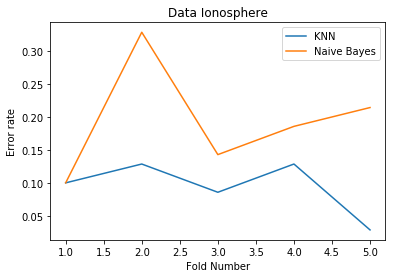

In [48]:
# Code for problem 4 goes here
"""
##From the above runs in the Question 2.2 I have alreaady picked the best K for the each data
## and the configurations are mentioned in the above section, please refer the same
## The best accuracies are as observeed 
##For Innonosphere k = 4 at l1 distance
##For Car Evaluatoion k =8 at l2 distance
## For Credit k = 5 at l1 distance

## here I am using sk learn implementation to run it faster
"""
from sklearn import neighbors


def avgTestErrorKNN(DataDict,k,distMetric):
    accuracyAtDiffSets = []
    for setNum in DataDict:

        KNNClassifier = neighbors.KNeighborsClassifier(n_neighbors = k,metric = distMetric)
        # Train the model on training data
        KNNClassifier.fit(DataDict[setNum]['Train'].iloc[:,:-1],DataDict[setNum]['Train'].iloc[:,-1])
        accuracyAtDiffSets.append(KNNClassifier.score(DataDict[setNum]['Test'].iloc[:,:-1],DataDict[setNum]['Test'].iloc[:,-1]))
    accuracyAtDiffSets = [1-i for i in accuracyAtDiffSets]
    return accuracyAtDiffSets


def avgTestErrosNaiveBayes(DataDict,NBClassifier):
    acc = []
    for i in range(5):
        Gnb = NBClassifier()

        y_pred = Gnb.fit(DataDict[i]['Train'].iloc[:,:-1], DataDict[i]['Train'].iloc[:,-1]).predict(DataDict[i]['Test'].iloc[:,:-1])
        acc.append(accuracy_score(y_pred,DataDict[i]['Test'].iloc[:,-1]))
    acc  = [1-i for i in acc]
    return acc
# listOfKNNErrors = [avgTestErrorKNN(DataIonosphereAll,2,'l2'),avgTestErrorKNN(DataCarAll,7,'l2'),avgTestErrorKNN(DataCreditAll,5,'l1')]

x1 = [1,2,3,4,5]
y1 = avgTestErrorKNN(DataIonosphereAll,4,'l1')
z1 = avgTestErrosNaiveBayes(DataIonosphereAll,GaussianNB)
plt.plot(x1,y1,label = "KNN")
plt.plot(x1,z1,label = "Naive Bayes")
plt.xlabel("Fold Number")
plt.ylabel("Error rate")
plt.title("Data Ionosphere")
plt.legend()




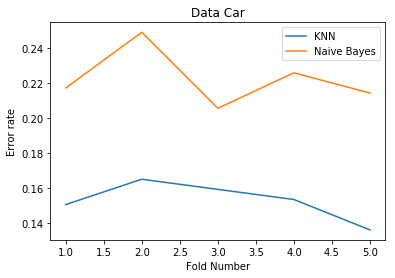

In [49]:
# sb.barplot(x= [1,2,3,4,5], 
#            y = [avgTestErrorKNN(DataCarAll,2,'l2'),avgTestErrosNaiveBayes(DataCarAll,BernoulliNB),
#                ]).set(xlabel='Algorithms', ylabel='Average misclassification Rate',title = "Data Car")


x1 = [1,2,3,4,5]
y1 = avgTestErrorKNN(DataCarAll,8,'l2')
z1 = avgTestErrosNaiveBayes(DataCarAll,BernoulliNB)
plt.title("Data Car")
plt.plot(x1,y1,label = "KNN")
plt.plot(x1,z1,label = "Naive Bayes")
plt.xlabel("Fold Number")
plt.ylabel("Error rate")
plt.legend()

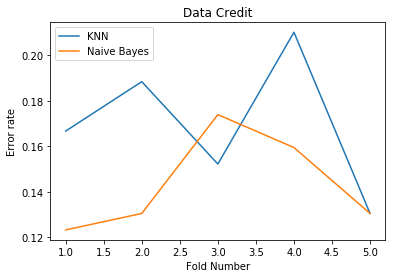

In [50]:
# sb.barplot(x= ['KNN', 'Naive Bayes'], 
#            y = [avgTestErrorKNN(DataCreditAll,2,'l2'),avgTestErrosNaiveBayes(DataCreditAll,BernoulliNB),
#                ]).set(xlabel='Algorithms', ylabel='Average misclassification Rate',title = "Data Credit")


x1 = [1,2,3,4,5]
y1 = avgTestErrorKNN(DataCreditAll,5,'l1')
z1 = avgTestErrosNaiveBayes(DataCreditAll,BernoulliNB)
plt.title("Data Credit")
plt.plot(x1,y1,label = "KNN")
plt.plot(x1,z1,label = "Naive Bayes")
plt.xlabel("Fold Number")
plt.ylabel("Error rate")
plt.legend()

## Problem 5: Support Vector Machines [20 points]

In this problem we are going to use the Iris dataset. This dataset has four features:

1.   sepal length
2.   sepal width
3.   petal length
4.   petal width

and three classes:

1.    Iris-Setosa
2.    Iris-Versicolour
3.    Iris-Virginica

In [42]:
from sklearn import svm, datasets

In [52]:
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

5.1 Create two plots:

1.   One using the sepal length (x-axis) and sepal width (y-axis),
2.   One using the petal length (x-axis) and petal width (y-axis),



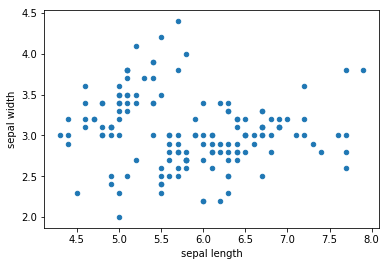

In [67]:
# Code for problem 5.1 goes here

irisDf = pd.DataFrame(iris.data, columns = ['sepal length', 'sepal width','petal length','petal width'])

irisDf.plot.scatter('sepal length', 'sepal width')

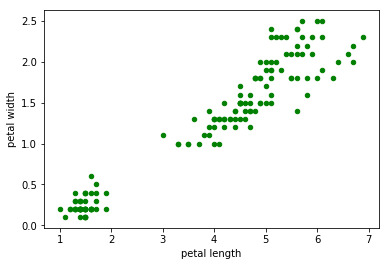

In [72]:
irisDf.plot.scatter('petal length', 'petal width', c = 'green')

5.2 Create a SVM with the following kernels and train it using the sepal features:


1.   SVC with linear kernel (use sklearn's svm.SVC with the kernel parameter 'linear'),
2.   LinearSVC (use sklearn's svm.LinearSVC),
3.   SVC with the RBF kernel,
4.   SVC with a polynomial kernel of degree 3

Plot the decision boundary for each of the four models. Hint: use matplotlib’s contourf and scatter functions. Be sure to label your axes.

[Citation :Reference used to solve this problem](https://scikit-learn.org/stable/auto_examples/svm/plot_iris.html)

https://scikit-learn.org/stable/auto_examples/svm/plot_iris.html

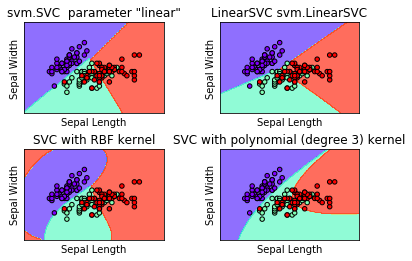

In [88]:
# Code for problem 5.2 goes here

svmModels = tuple((svm.SVC(kernel='linear'),
          svm.LinearSVC(),
          svm.SVC(kernel='rbf', gamma=0.7),
          svm.SVC(kernel='poly', degree=3)))
svmModels = [clf.fit(X, y) for clf in svmModels]



def make_meshgrid(x, y, h=.02):

    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy
def plot_contours(ax, clf, xx, yy, **params):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


titles = ('svm.SVC  parameter "linear"',
          'LinearSVC svm.LinearSVC',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')




5.3 Repeat 5.2 using the petal features.

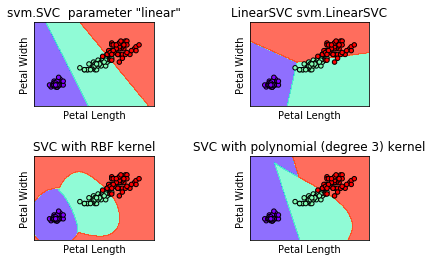

In [94]:
# Code for problem 5.3 goes here


X2 = iris.data[:, 2:]
y = iris.target
svmModels = tuple((svm.SVC(kernel='linear'),
          svm.LinearSVC(),
          svm.SVC(kernel='rbf', gamma=0.7),
          svm.SVC(kernel='poly', degree=3)))
svmModels = [clf.fit(X2, y) for clf in svmModels]
X0, X1 = X2[:, 0], X2[:, 1]
xx, yy = make_meshgrid(X0, X1)


fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.8, hspace=0.6)
for clf, title, ax in zip(svmModels, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.rainbow, alpha=0.7)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.rainbow, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Petal Length')
    ax.set_ylabel('Petal Width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()